# 1.0 Libraries

In [196]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

import json

import torch
from torch.distributions import Categorical
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from transformers import BertForSequenceClassification, BertTokenizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 2.0 Set up

In [197]:
train_data_path = "/content/gdrive/MyDrive/Colab Notebooks/MNLP/Homework I - task 4/binary/train.jsonl"
dev_data_path = "/content/gdrive/MyDrive/Colab Notebooks/MNLP/Homework I - task 4/binary/dev.jsonl"
test_data_path = "/content/gdrive/MyDrive/Colab Notebooks/MNLP/Homework I - task 4/gold_truth/binary/test.jsonl"

In [198]:
def reformat_jsonl(input_path, output_path):
  id_seq = 0
  with open(input_path, "r") as input_file, open(output_path, "w") as output_file:
    for line in input_file:
      json_data = json.loads(line)
      reformatted_json_data = {
          "id" : id_seq,
          "lemma" : json_data["lemma"],
          "sentence1" : json_data["sentence1"],
          "sentence2" : json_data["sentence2"],
          "start1" : json_data["start1"],
          "end1" : json_data["end1"],
          "start2" : json_data["start2"],
          "end2" : json_data["end2"],
          "choices" : ["Ambiguo", "Non ambiguo"],
          "label" : json_data["label"]
      }
      json.dump(reformatted_json_data, output_file)
      output_file.write('\n')
      id_seq += 1

def read_lines_jsonl(file_path, num_lines):
  with open(file_path, 'r') as f:
    json_list = list(f)
    for line in json_list[:num_lines]:
      data = json.loads(line)
      print(data)

In [199]:
# italian train data
reformat_jsonl(train_data_path, "WiC-ITA_train.jsonl")
read_lines_jsonl("WiC-ITA_train.jsonl", num_lines = 10) # preview of the first 10 lines

{'id': 0, 'lemma': 'affare', 'sentence1': 'E visto che mi lascia GPS , Ecoscandaglio , TUTTE le dotazioni obbligatorie in ottimo stato ( razzi nuovi , ecc ) un sacco di cime ( due ancora nuove imballate ) , gonfiatore , pezzi vari di ricambio , ecc ecc ecc con un supplemento è affare fatto .', 'sentence2': 'La rivista nordamericana segnala come presunti sospetti il milionario e potente della stampa venezuelana , Gustavo Cisnero , che avrebbe ricevuto istruzioni da Otto Reich , massimo responsabile della Casa Bianca per gli Affari Latinoamericani .', 'start1': 235, 'end1': 241, 'start2': 220, 'end2': 226, 'choices': ['Ambiguo', 'Non ambiguo'], 'label': 0}
{'id': 1, 'lemma': 'elemento', 'sentence1': "In particolare , l' elemento più scandaloso del provvedimento che ci accingiamo a votare è rappresentato dagli articoli 7 e 8 su cui , questa mattina , abbiamo condotto , come opposizione , una lunga battaglia di buon senso .", 'sentence2': 'Il Fondo mostra di apprezzare " certi elementi di 

In [200]:
# italian test data
reformat_jsonl(test_data_path, "WiC-ITA_test.jsonl")
read_lines_jsonl("WiC-ITA_test.jsonl", num_lines = 10) # preview of the first 10 lines

{'id': 0, 'lemma': 'minore', 'sentence1': "Dopo innumerevoli provini sono stati scelti 15 attori per i ruoli principali , 200 per le parti minori e quasi 4000 comparse che animeranno le 24 puntate da 50 minuti ognuna trasmesse ogni domenica con due episodi l' uno di seguito all' altro .", 'sentence2': 'Il direttore di Micromega ha detto che , dopo questi due giorni , ci troviamo di fronte alla scelta fra un bene e un male minore .', 'start1': 96, 'end1': 102, 'start2': 122, 'end2': 128, 'choices': ['Ambiguo', 'Non ambiguo'], 'label': 1}
{'id': 1, 'lemma': 'rigore', 'sentence1': "44 ' st Napoli vicinissimo al gol con Floro Flores lanciato in area di rigore da un colpo di testa di Stellone : sull' incursione dell' attaccante napoletano Casazza con un' uscita disperata riesce a respingere in angolo .", 'sentence2': "Nell' altra semifinale i simpaticissimi e tecnicamente validissimi ragazzi di Torino avevano la meglio ai calci di rigore della sezione di Roma 2 , dopo che i tempi regolament

In [201]:
# italian dev data
reformat_jsonl(dev_data_path, "WiC-ITA_dev.jsonl")
read_lines_jsonl("WiC-ITA_dev.jsonl", num_lines = 10) # preview of the first 10 lines

{'id': 0, 'lemma': 'delicatezza', 'sentence1': 'Il presidente AZZOLLINI , stante la delicatezza dei temi oggetto del provvedimento , ritiene opportuno richiedere la predisposizione di una relazione tecnica .', 'sentence2': 'Montare la panna senza zucchero in modo che diventi molto solida , quindi unirla al composto avendo cura di mescolarla con molta delicatezza .', 'start1': 36, 'end1': 47, 'start2': 129, 'end2': 140, 'choices': ['Ambiguo', 'Non ambiguo'], 'label': 0}
{'id': 1, 'lemma': 'fede', 'sentence1': "Per quanto riguarda gli adolescenti l' indagine rileva che la fede risulta più diffusa tra le ragazze : il 76,4 % delle adolescenti è credente , contro il 71,1 % dei coetanei di sesso maschile .", 'sentence2': 'Quando un datore di lavoro viene perseguito in ottemperanza alle disposizioni adottate in virtù del presente articolo , egli deve avere il diritto di produrre la prova della propria buona fede .', 'start1': 62, 'end1': 66, 'start2': 188, 'end2': 192, 'choices': ['Ambiguo', 

# 3.0 Prompt formulation

In [202]:
prompts = [
    "Il significato della parola '{lemma}' è (Ambiguo) o (Non ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'?",
    "Nella frase '{sentence1}' e nella frase '{sentence2}', il significato della parola '{lemma}' risulta (Ambiguo) o (Non ambiguo)?",
    "Data la parola '{lemma}', valuta se il suo significato risulta essere (Ambiguo) o (Non Ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'."
]

In [ ]:
def save_prompts_jsonl(prompts, file_path):
  json_prompts = []
  for prompt in prompts:
    json_prompts.append({"prompt": prompt})

  with open(file_path, "w") as output_file:
    for json_prompt in json_prompts:
      json.dump(json_prompt, output_file)
      output_file.write("\n")

In [ ]:
save_prompts_jsonl(prompts, "prompts.jsonl")
read_lines_jsonl("prompts.jsonl", num_lines = 3)

{'prompt': "Il significato della parola '{lemma}' è (Ambiguo) o (Non ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'?"}
{'prompt': "Nella frase '{sentence1}' e nella frase '{sentence2}', il significato della parola '{lemma}' risulta (Ambiguo) o (Non ambiguo)?"}
{'prompt': "Data la parola '{lemma}', valuta se il suo significato risulta essere (Ambiguo) o (Non Ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'."}


# 4.0 Performance Evaluation

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
def evaluate_prompt(tokenizer, model, prompt, data_file):
  formatted_prompts, y_true, y_pred, score = [], [], [], []

  with open(data_file, "r") as f:
    json_data = list(f)
    for line in json_data:
      pair = json.loads(line)
      id = pair['id']
      lemma = pair['lemma']
      sentence1 = pair['sentence1']
      sentence2 =  pair['sentence2']
      start1 = pair['start1']
      end1 = pair['end1']
      start2 = pair['start2']
      end2 = pair['end2']
      choices = pair['choices']
      label = pair['label']

      formatted_prompt = prompt.format(lemma = lemma, sentence1 = sentence1, sentence2 = sentence2)
      input = tokenizer(formatted_prompt, truncation=True, return_tensors = "pt").to(device)

      with torch.no_grad():
        output = model(input["input_ids"].to(device))

      probabilities = torch.softmax(output["logits"][0], -1).tolist()
      normalized_probabilities = [prob / sum(probabilities[:2]) for prob in probabilities[:2]]
      predicted_label = np.argmax(normalized_probabilities)
      prediction_score = normalized_probabilities[predicted_label]

      formatted_prompts.append(formatted_prompt)
      y_true.append(label)
      y_pred.append(predicted_label)
      score.append(prediction_score)

    return formatted_prompts, y_true, y_pred, score


def visualize_results(results, num_results):
  choices = ["Ambiguo", "Non Ambiguo"]
  for prompt in range(len(results)):
    for n in range(num_results):
      print("Prompt: ", results[prompt][0][n])
      print("True label: ", choices[results[prompt][1][n]])
      print("Predicted label: ", choices[results[prompt][2][n]])
      print("Prediction score: ", round(results[prompt][3][n], 3))
      print(" ")

In [ ]:
def compute_metrics(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  cf_matrix = confusion_matrix(y_true, y_pred)

  return accuracy, precision, recall, f1, cf_matrix


def print_confusion_matrix(metrics, type):
  for n in range(len(metrics)):
    print(f"{type} Confusion Matrix for the Prompt {n}")
    print("Prompt: ", prompts[n])

    # Confusion Matrix Plot
    cf_matrix = metrics[n][4]
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.heatmap(cf_matrix, annot = True, fmt = '.0f')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    plt.show()

    print("Total Predictions: ", np.sum(cf_matrix))
    print("Correct Predictions: ", np.trace(cf_matrix))
    print("----------------------------------------------------------------")
    print(" ")

def print_overall_statistics(train_metrics, test_metrics, dev_metrics, prompts):
  comparison_table = []
  for id, prompt in enumerate(prompts):
    data = {}
    for dtype, metrics in zip(['Train', 'Test', 'Dev'], [train_metrics, test_metrics, dev_metrics]):
      accuracy, precision, recall, f1, cf_matrix = metrics[id]
      data[f'{dtype} Accuracy'] = round(accuracy, 3)
      data[f'{dtype} Precision'] = round(precision, 3)
      data[f'{dtype} Recall'] = round(recall, 3)
      data[f'{dtype} F1-score'] = round(f1, 3)
    comparison_table.append(data)
  return pd.DataFrame(comparison_table).transpose()

## 4.1 mDeBERTa

In [ ]:
model_name = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
tokenizer_mDeBERTa = AutoTokenizer.from_pretrained(model_name)
model_mDeBERTa = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

In [ ]:
train_results, test_results, dev_results = [], [], []

for prompt in prompts:
  formatted_prompt, y_true, y_pred, score = evaluate_prompt(tokenizer_mDeBERTa, model_mDeBERTa, prompt, "WiC-ITA_train.jsonl")
  train_results.append([formatted_prompt, y_true, y_pred, score])

  formatted_prompt, y_true, y_pred, score = evaluate_prompt(tokenizer_mDeBERTa, model_mDeBERTa,  prompt, "WiC-ITA_test.jsonl")
  test_results.append([formatted_prompt, y_true, y_pred, score])

  formatted_prompt, y_true, y_pred, score = evaluate_prompt(tokenizer_mDeBERTa, model_mDeBERTa, prompt, "WiC-ITA_dev.jsonl")
  dev_results.append([formatted_prompt, y_true, y_pred, score])

In [ ]:
visualize_results(train_results, num_results = 2) # preview of the first 2 train results for each prompt

Prompt:  Il significato della parola 'affare' è (Ambiguo) o (Non ambiguo) nella frase 'E visto che mi lascia GPS , Ecoscandaglio , TUTTE le dotazioni obbligatorie in ottimo stato ( razzi nuovi , ecc ) un sacco di cime ( due ancora nuove imballate ) , gonfiatore , pezzi vari di ricambio , ecc ecc ecc con un supplemento è affare fatto .' e nella frase 'La rivista nordamericana segnala come presunti sospetti il milionario e potente della stampa venezuelana , Gustavo Cisnero , che avrebbe ricevuto istruzioni da Otto Reich , massimo responsabile della Casa Bianca per gli Affari Latinoamericani .'?
True label:  Ambiguo
Predicted label:  Non Ambiguo
Prediction score:  0.893
 
Prompt:  Il significato della parola 'elemento' è (Ambiguo) o (Non ambiguo) nella frase 'In particolare , l' elemento più scandaloso del provvedimento che ci accingiamo a votare è rappresentato dagli articoli 7 e 8 su cui , questa mattina , abbiamo condotto , come opposizione , una lunga battaglia di buon senso .' e nell

In [ ]:
train_metrics, test_metrics, dev_metrics = [], [], []

for prompt in range(len(prompts)):
  accuracy, precision, recall, f1, cf_matrix = compute_metrics(train_results[prompt][1], train_results[prompt][2])
  train_metrics.append([accuracy, precision, recall, f1, cf_matrix])

  accuracy, precision, recall, f1, cf_matrix = compute_metrics(test_results[prompt][1], test_results[prompt][2])
  test_metrics.append([accuracy, precision, recall, f1, cf_matrix])

  accuracy, precision, recall, f1, cf_matrix = compute_metrics(dev_results[prompt][1], dev_results[prompt][2])
  dev_metrics.append([accuracy, precision, recall, f1, cf_matrix])

### Confusion Matrices

Train Confusion Matrix for the Prompt 0
Prompt:  Il significato della parola '{lemma}' è (Ambiguo) o (Non ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'?


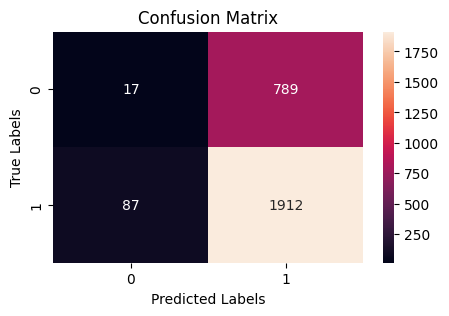

Total Predictions:  2805
Correct Predictions:  1929
----------------------------------------------------------------
 
Train Confusion Matrix for the Prompt 1
Prompt:  Nella frase '{sentence1}' e nella frase '{sentence2}', il significato della parola '{lemma}' risulta (Ambiguo) o (Non ambiguo)?


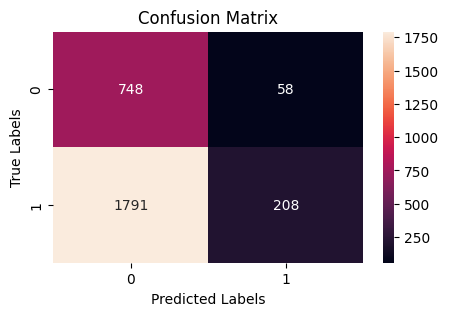

Total Predictions:  2805
Correct Predictions:  956
----------------------------------------------------------------
 
Train Confusion Matrix for the Prompt 2
Prompt:  Data la parola '{lemma}', valuta se il suo significato risulta essere (Ambiguo) o (Non Ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'.


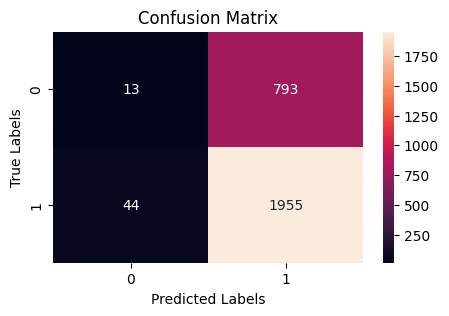

Total Predictions:  2805
Correct Predictions:  1968
----------------------------------------------------------------
 


In [ ]:
# Train Confusion Matrix for each prompt
print_confusion_matrix(train_metrics, "Train")

Test Confusion Matrix for the Prompt 0
Prompt:  Il significato della parola '{lemma}' è (Ambiguo) o (Non ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'?


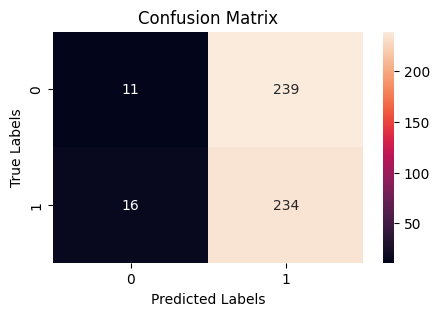

Total Predictions:  500
Correct Predictions:  245
----------------------------------------------------------------
 
Test Confusion Matrix for the Prompt 1
Prompt:  Nella frase '{sentence1}' e nella frase '{sentence2}', il significato della parola '{lemma}' risulta (Ambiguo) o (Non ambiguo)?


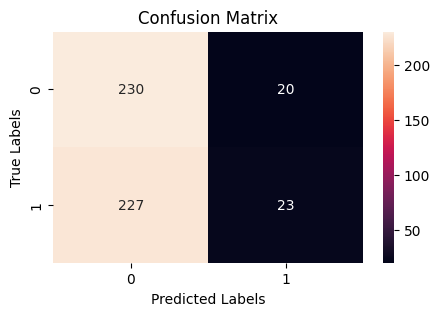

Total Predictions:  500
Correct Predictions:  253
----------------------------------------------------------------
 
Test Confusion Matrix for the Prompt 2
Prompt:  Data la parola '{lemma}', valuta se il suo significato risulta essere (Ambiguo) o (Non Ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'.


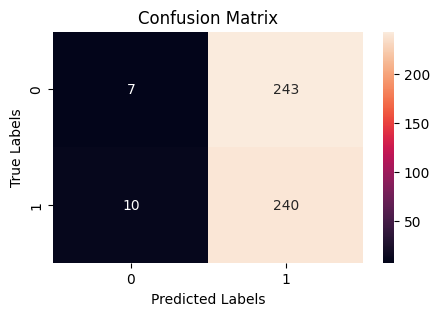

Total Predictions:  500
Correct Predictions:  247
----------------------------------------------------------------
 


In [ ]:
# Test Confusion Matrix for each prompt
print_confusion_matrix(test_metrics, "Test")

Dev Confusion Matrix for the Prompt 0
Prompt:  Il significato della parola '{lemma}' è (Ambiguo) o (Non ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'?


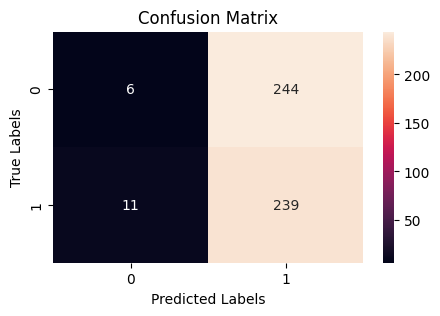

Total Predictions:  500
Correct Predictions:  245
----------------------------------------------------------------
 
Dev Confusion Matrix for the Prompt 1
Prompt:  Nella frase '{sentence1}' e nella frase '{sentence2}', il significato della parola '{lemma}' risulta (Ambiguo) o (Non ambiguo)?


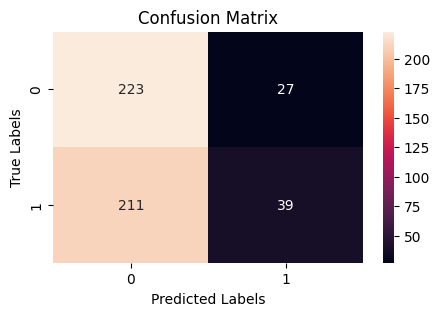

Total Predictions:  500
Correct Predictions:  262
----------------------------------------------------------------
 
Dev Confusion Matrix for the Prompt 2
Prompt:  Data la parola '{lemma}', valuta se il suo significato risulta essere (Ambiguo) o (Non Ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'.


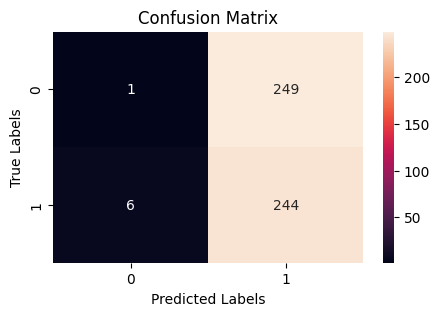

Total Predictions:  500
Correct Predictions:  245
----------------------------------------------------------------
 


In [ ]:
# Dev Confusion Matrix for each prompt
print_confusion_matrix(dev_metrics, "Dev")

### Overall Statistics

In [ ]:
# Overall Statistics
print_overall_statistics(train_metrics, test_metrics, dev_metrics, prompts)

,0,1,2
Train Accuracy,0.688,0.341,0.702
Train Precision,0.708,0.782,0.711
Train Recall,0.956,0.104,0.978
Train F1-score,0.814,0.184,0.824
Test Accuracy,0.490,0.506,0.494
Test Precision,0.495,0.535,0.497
Test Recall,0.936,0.092,0.960
Test F1-score,0.647,0.157,0.655
Dev Accuracy,0.490,0.524,0.490
Dev Precision,0.495,0.591,0.495


## 4.2 BERT base multilingual

In [ ]:
tokenizer_mBERT = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model_mBERT = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_results, test_results, dev_results = [], [], []

for prompt in prompts:
  formatted_prompt, y_true, y_pred, score = evaluate_prompt(tokenizer_mBERT, model_mBERT, prompt, "WiC-ITA_train.jsonl")
  train_results.append([formatted_prompt, y_true, y_pred, score])

  formatted_prompt, y_true, y_pred, score = evaluate_prompt(tokenizer_mBERT, model_mBERT,  prompt, "WiC-ITA_test.jsonl")
  test_results.append([formatted_prompt, y_true, y_pred, score])

  formatted_prompt, y_true, y_pred, score = evaluate_prompt(tokenizer_mBERT, model_mBERT, prompt, "WiC-ITA_dev.jsonl")
  dev_results.append([formatted_prompt, y_true, y_pred, score])

In [ ]:
visualize_results(train_results, 2) # preview of the first 2 train results for each prompt

Prompt:  Il significato della parola 'affare' è (Ambiguo) o (Non ambiguo) nella frase 'E visto che mi lascia GPS , Ecoscandaglio , TUTTE le dotazioni obbligatorie in ottimo stato ( razzi nuovi , ecc ) un sacco di cime ( due ancora nuove imballate ) , gonfiatore , pezzi vari di ricambio , ecc ecc ecc con un supplemento è affare fatto .' e nella frase 'La rivista nordamericana segnala come presunti sospetti il milionario e potente della stampa venezuelana , Gustavo Cisnero , che avrebbe ricevuto istruzioni da Otto Reich , massimo responsabile della Casa Bianca per gli Affari Latinoamericani .'?
True label:  Ambiguo
Predicted label:  Ambiguo
Prediction score:  0.618
 
Prompt:  Il significato della parola 'elemento' è (Ambiguo) o (Non ambiguo) nella frase 'In particolare , l' elemento più scandaloso del provvedimento che ci accingiamo a votare è rappresentato dagli articoli 7 e 8 su cui , questa mattina , abbiamo condotto , come opposizione , una lunga battaglia di buon senso .' e nella fr

In [ ]:
train_metrics, test_metrics, dev_metrics = [], [], []

for prompt in range(len(prompts)):
  accuracy, precision, recall, f1, cf_matrix = compute_metrics(train_results[prompt][1], train_results[prompt][2])
  train_metrics.append([accuracy, precision, recall, f1, cf_matrix])

  accuracy, precision, recall, f1, cf_matrix = compute_metrics(test_results[prompt][1], test_results[prompt][2])
  test_metrics.append([accuracy, precision, recall, f1, cf_matrix])

  accuracy, precision, recall, f1, cf_matrix = compute_metrics(dev_results[prompt][1], dev_results[prompt][2])
  dev_metrics.append([accuracy, precision, recall, f1, cf_matrix])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

### Confusion Matrices

Train Confusion Matrix for the Prompt 0
Prompt:  Il significato della parola '{lemma}' è (Ambiguo) o (Non ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'?


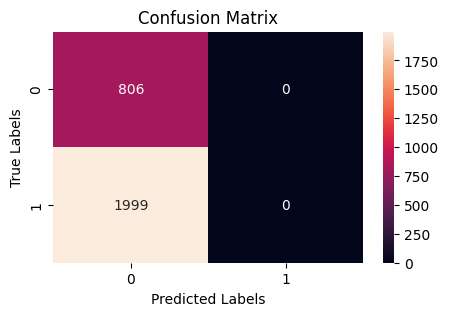

Total Predictions:  2805
Correct Predictions:  806
----------------------------------------------------------------
 
Train Confusion Matrix for the Prompt 1
Prompt:  Nella frase '{sentence1}' e nella frase '{sentence2}', il significato della parola '{lemma}' risulta (Ambiguo) o (Non ambiguo)?


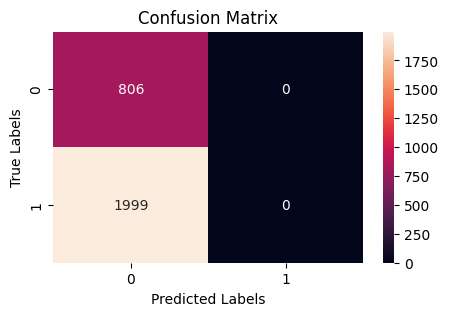

Total Predictions:  2805
Correct Predictions:  806
----------------------------------------------------------------
 
Train Confusion Matrix for the Prompt 2
Prompt:  Data la parola '{lemma}', valuta se il suo significato risulta essere (Ambiguo) o (Non Ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'.


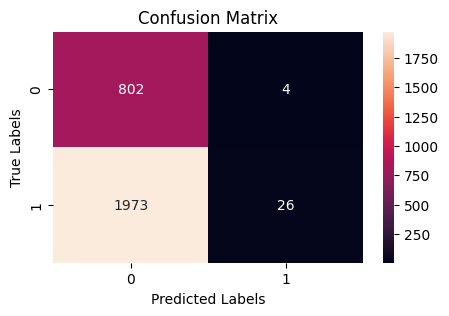

Total Predictions:  2805
Correct Predictions:  828
----------------------------------------------------------------
 


In [ ]:
# Train Confusion Matrix for each prompt
print_confusion_matrix(train_metrics, "Train")

Test Confusion Matrix for the Prompt 0
Prompt:  Il significato della parola '{lemma}' è (Ambiguo) o (Non ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'?


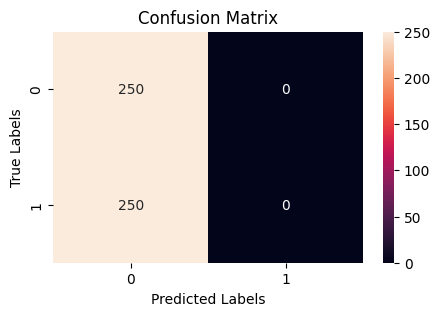

Total Predictions:  500
Correct Predictions:  250
----------------------------------------------------------------
 
Test Confusion Matrix for the Prompt 1
Prompt:  Nella frase '{sentence1}' e nella frase '{sentence2}', il significato della parola '{lemma}' risulta (Ambiguo) o (Non ambiguo)?


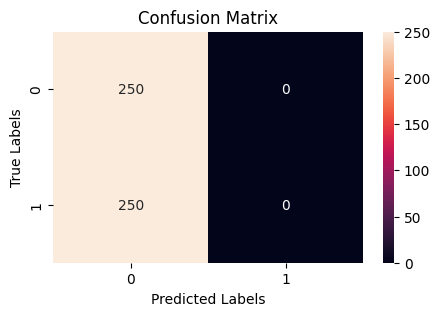

Total Predictions:  500
Correct Predictions:  250
----------------------------------------------------------------
 
Test Confusion Matrix for the Prompt 2
Prompt:  Data la parola '{lemma}', valuta se il suo significato risulta essere (Ambiguo) o (Non Ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'.


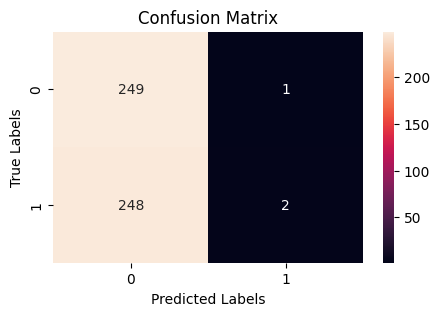

Total Predictions:  500
Correct Predictions:  251
----------------------------------------------------------------
 


In [ ]:
# Test Confusion Matrix for each prompt
print_confusion_matrix(test_metrics, "Test")

Dev Confusion Matrix for the Prompt 0
Prompt:  Il significato della parola '{lemma}' è (Ambiguo) o (Non ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'?


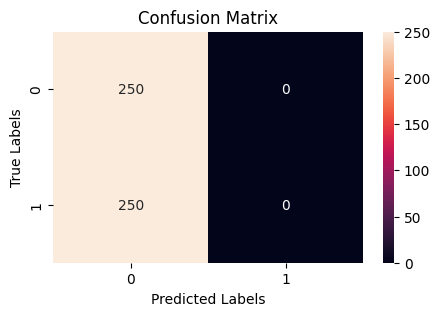

Total Predictions:  500
Correct Predictions:  250
----------------------------------------------------------------
 
Dev Confusion Matrix for the Prompt 1
Prompt:  Nella frase '{sentence1}' e nella frase '{sentence2}', il significato della parola '{lemma}' risulta (Ambiguo) o (Non ambiguo)?


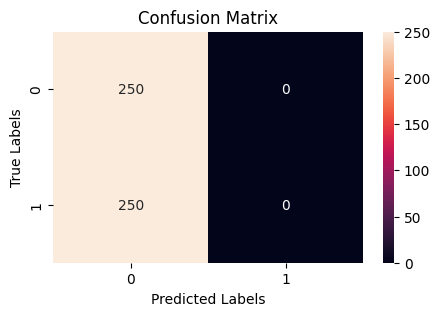

Total Predictions:  500
Correct Predictions:  250
----------------------------------------------------------------
 
Dev Confusion Matrix for the Prompt 2
Prompt:  Data la parola '{lemma}', valuta se il suo significato risulta essere (Ambiguo) o (Non Ambiguo) nella frase '{sentence1}' e nella frase '{sentence2}'.


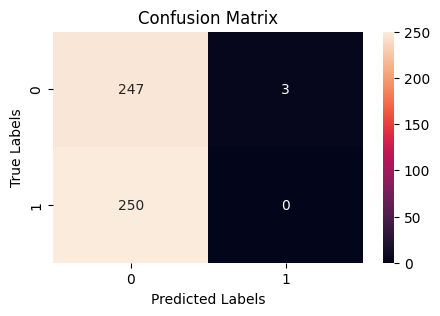

Total Predictions:  500
Correct Predictions:  247
----------------------------------------------------------------
 


In [ ]:
# Dev Confusion Matrix for each prompt
print_confusion_matrix(dev_metrics, "Dev")

### Overall Statistics

In [ ]:
# Overall Statistics
print_overall_statistics(train_metrics, test_metrics, dev_metrics, prompts)

,0,1,2
Train Accuracy,0.287,0.287,0.295
Train Precision,0.000,0.000,0.867
Train Recall,0.000,0.000,0.013
Train F1-score,0.000,0.000,0.026
Test Accuracy,0.500,0.500,0.502
Test Precision,0.000,0.000,0.667
Test Recall,0.000,0.000,0.008
Test F1-score,0.000,0.000,0.016
Dev Accuracy,0.500,0.500,0.494
Dev Precision,0.000,0.000,0.000
